# Short-time processing of speech signals

In the [short-time *analysis*](Short-time%20analysis.ipynb) section we already discussed speech signals and analysis methods, and found that we need to split the signal into shorter segments and apply windowing functions. Here we discuss what extra steps we need to consider when we want to *process* signals, that is, when we want to modify the signal.

To process a windowed signal, we thus need the steps:
1. windowing
2. time-frequency transform such as the DFT (*optional*)
3. apply the desired processing
4. inverse time-frequency transform (*when DFT was applied*)
5. reverse of windowing (?).

Here the analysis steps 1-2 were already discussed and the desired processing is whatever modification to the signal that you might have. The question is thus about the inverse transforms in steps 4 and 5. 
Time-frequency transforms such as the [discrete Fourier transform (DFT)](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) and the [discrete cosine transform (DCT)](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) are orthonormal and have well-known fast algorithms for their inverses. The main challenge is thus the *"reverse of windowing"*, whatever that might be.

The direct approach of just multiplying with the inverse of the windowing function has a problem.

In [1]:
# Initialization
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import scipy.fft
import numpy as np

import helper_functions # local file helper_functions.py

filename = 'sounds/windowing_test.wav'

# read from storage
fs, data = wavfile.read(filename)
data = data[:,0]

window_length_ms = 30
window_step_ms = window_length_ms/2
spectrum_length = 5000
window_length = int(window_length_ms*fs/1000)
window_step = int(window_step_ms*fs/1000)
windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)**2
total_length = len(data)

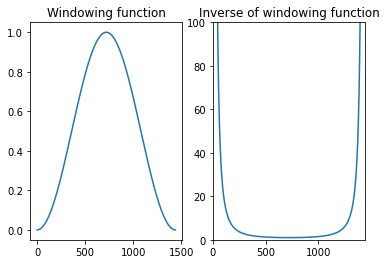

In [2]:
plt.subplot(121)
plt.plot(windowing_function)
plt.title('Windowing function')
plt.subplot(122)
plt.plot(windowing_function**-1)
plt.axis([0, window_length, 0, 100])
plt.title('Inverse of windowing function')
plt.show()

Namely, near the ends of the window, the windowing function goes smoothly to zero and thus the inverse of the windowing function approaches infinity. That clearly leads to numerical issues; very small changes in the windowed signal can lead to arbitrarily large samples after inverse windowing.

We thus need a method which does not rely on inverting the windowing function.

## Overlap-add

A majority of modern speech processing is based on the overlap-add method, where the input signal is windowed in overlapping segments, such that when the overlapping parts are added together, we can perfectly reconstruct the original signal. It is like a cross-fade between subsequent windows. 

The most common scenario where overlap-add cannot be used are applications which require a very low algorithmic delay. For example, stage microphones at concerts and theaters require a low-delay, such that interaction between people on the stage is not disrupted. Almost always otherwise, the best option is overlap-add.

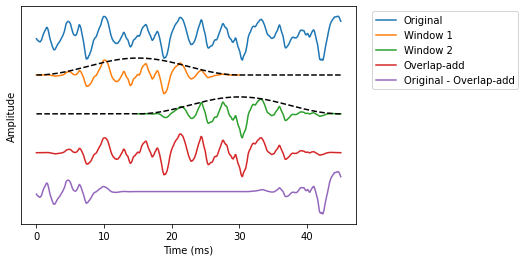

In [3]:
# choose segment from random position in sample
starting_position1 =  np.random.randint(total_length - window_length - window_step)
starting_position2 = starting_position1 + window_step
data_vectorx = data[starting_position1:(starting_position1+window_length+window_step)]
data_vector1 = data[starting_position1:(starting_position1+window_length),]
window1 = data_vector1*windowing_function
time_vector1 = np.linspace(0,window_length_ms,window_length)

data_vector2 = data[starting_position2:(starting_position2+window_length),]
window2 = data_vector2*windowing_function
time_vector2 = np.linspace(0,window_length_ms,window_length)+window_step_ms

zero_vector = np.zeros(window_step,)
time_vectorx = np.linspace(0,window_length_ms+window_step_ms,window_length+window_step)
window1x = np.concatenate((window1,zero_vector))
window2x = np.concatenate((zero_vector,window2))

window_fn1 = np.concatenate((windowing_function,zero_vector))
window_fn2 = np.concatenate((zero_vector,windowing_function))
window_scale = np.max(np.abs(data_vectorx))*.7
window_fn1 *= window_scale
window_fn2 *= window_scale

# overlap add
window_ola = window1x + window2x

display_shift = np.max(np.abs(data_vector1))*1.7

fig, ax = plt.subplots()
ax.plot(time_vectorx,data_vectorx,label='Original')
ax.plot(time_vector1,window1-display_shift,label='Window 1')
ax.plot(time_vector2,window2-display_shift*2,label='Window 2')
ax.plot(time_vectorx,window_ola-display_shift*3,label='Overlap-add')
ax.plot(time_vectorx,data_vectorx-window_ola-display_shift*4,label='Original - Overlap-add')
ax.plot(time_vectorx,window_fn1-display_shift,'k--')
ax.plot(time_vectorx,window_fn2-display_shift*2,'k--')
ax.legend(bbox_to_anchor=(1.5, 1),loc='upper right')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude')
ax.set_yticks([])
plt.show()

In the above example, we see two overlapping windows extracted from the original signal. When we add the two together we obtain the "Overlap-add" signal which, we subtracted from the original, is zero in the whole region of the overlap. At the left and right ends, where we do not have an overlapping window, we do not get perfect reconstruction.

### Windowing and reconstruction
Overlapping segments are added together (fade-in/fade-out).
Windowing should be chosen such that reconstruction is exactly  equal to the original.
- Let original signal be $x_n$.
- The left and right parts of overlap windows are then $w_{L,n}$ and $w_{R,n}$ and the windowed signals are $w_{L,n}x_n$ and $w_{R,n}x_n$.
- The reconstruction is $\hat x_n = w_{L,n}x_n + w_{R,n}x_n = (w_{L,n} + w_{R,n})x_n$.
- With $w_{L,n} + w_{R,n} = 1$ we obtain *perfect reconstruction*, $x_n = \hat x_n$.

The window in the above example already adheres to this requirement.

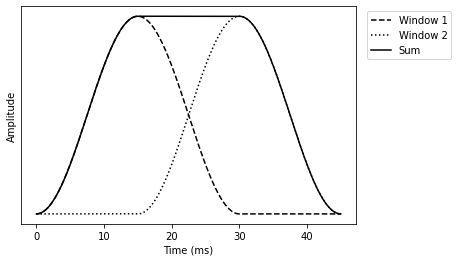

In [4]:
fig, ax = plt.subplots()
ax.plot(time_vectorx,window_fn1,'k--',label='Window 1')
ax.plot(time_vectorx,window_fn2,'k:',label='Window 2')
ax.plot(time_vectorx,window_fn1+window_fn2,'k',label='Sum')
ax.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude')
ax.set_yticks([])
plt.show()

### Windowing and processing

The whole point of windowing for processing was that we could modify the windowed signal and that we can then synthesise the modified signal. Suppose $x':=wx$ is the windowed signal and the modified signal is $\hat x'$, such that the modification part is $e=x'-\hat x$. In overlap-add, we would then take multiple modified windows $\hat x_k'$ and add them together. We have already seen that the part which corresponds to the original signal $x'$ will perfectly reconstruct to the original signal. The question is however what happens to the modification part? 

With a direct implementation, we would just add the modifications together. There is then no guarantee that consecutive modifications play nicely together and we can, for example, have discontinuities between windows.

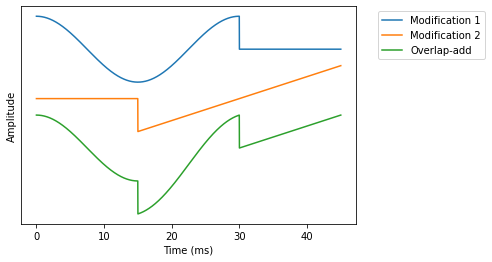

In [5]:
# choose segment from random position in sample
zero_vector = np.zeros(window_step,)
time_vectorx = np.linspace(0,window_length_ms+window_step_ms,window_length+window_step)

# modifications
mod1 = np.cos(np.linspace(0,2*np.pi,window_length))
mod2 = np.linspace(-1,1,window_length)
mod1x = np.concatenate((mod1,zero_vector))
mod2x = np.concatenate((zero_vector,mod2))

# overlap add
window_ola = mod1x + mod2x

display_shift = 1.5

fig, ax = plt.subplots()
ax.plot(time_vectorx,mod1x,label='Modification 1')
ax.plot(time_vectorx,mod2x-display_shift*1,label='Modification 2')
ax.plot(time_vectorx,window_ola-display_shift*2,label='Overlap-add')
ax.legend(bbox_to_anchor=(1.4, 1),loc='upper right')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude')
ax.set_yticks([])
plt.show()

We therefore need to multiply also the modified windows with a windowing function. 

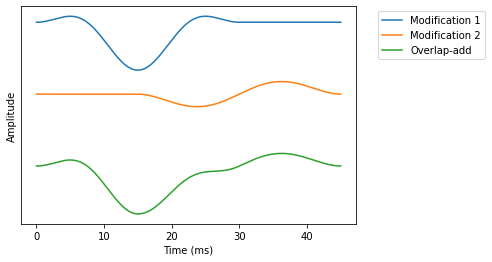

In [6]:
# choose segment from random position in sample
zero_vector = np.zeros(window_step,)
time_vectorx = np.linspace(0,window_length_ms+window_step_ms,window_length+window_step)

# modifications
mod1 = np.cos(np.linspace(0,2*np.pi,window_length))*windowing_function
mod2 = np.linspace(-1,1,window_length)*windowing_function
mod1x = np.concatenate((mod1,zero_vector))
mod2x = np.concatenate((zero_vector,mod2))

# overlap add
window_ola = mod1x + mod2x

display_shift = 1.5

fig, ax = plt.subplots()
ax.plot(time_vectorx,mod1x,label='Modification 1')
ax.plot(time_vectorx,mod2x-display_shift*1,label='Modification 2')
ax.plot(time_vectorx,window_ola-display_shift*2,label='Overlap-add')
ax.legend(bbox_to_anchor=(1.4, 1),loc='upper right')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude')
ax.set_yticks([])
plt.show()

#### Algorithm ``Overlap-add''
Let $w_{in,n}$ and $w_{out,n}$ be the input and output windowing functions.

1. The input signal is $x_n$ is windowed at the input to obtain  $w_{in,n}x_n$.

2. The windowed signal is modified with $e_n$ to obtain $w_{in,n}x_n+e_n$.

3. We apply an output window $w_{out,n}$ to the modified signal to obtain $w_{out,n}(w_{in,n}x_n+e_n)$.

4. Add subsequent, overlapping windows together to obtain the output signal.

Then if the output windows go to zero at the border, then the output signal will be continuous.
With no-modification $e_n=0$, the output is $w_{out,n}w_{in,n}x_n$.
In other words, if the left and right parts add up $$ w_{L,out,n}w_{L,in,n} + w_{R,out,n}w_{R,in,n} = 1 $$ then we have perfect reconstruction.

If we the modification is uniform white noise, then the  modification part overlap is $w_{L,out,n}e_{L,n} + w_{R,out,n}e_{R,n}$.
The energy expectation of the modification is then 

$$  E\left[\left(w_{L,out,n}e_{L,n} + w_{R,out,n}e_{R,n}\right)^2\right]  = \left(w^2_{L,out,n} + w^2_{R,out,n}\right) E[e_n^2]. $$

If $w^2_{L,out,n} + w^2_{R,out,n}=1$ then output energy is uniform.
To fulfil the criteria, we can set the input and output    windows to be the same $w_{in,n} = w_{out,n}$.

We can then require that (*Princen-Bradley condition*) 

$$  
\boxed{w^2_{L,n} + w^2_{R,n} = 1}. 
$$ 

and that $w_n$ goes to zero at the borders.
Overlap-add obtains the following properties:

- **Perfect reconstruction** -- If there is no modification, we can reconstruct the original signal.
    
- **Continuous output** -- There are no discontinuities.
    
- **Uniform noise energy** -- Output noise does not have temporal   structure (noise has a smooth energy envelope).
    
One such windowing function is the half-sine 

$$  
w_n = \sin\left(\frac{\pi n}{N}\right).\qquad\text{(It is the square root of a Hann-window.)}
$$   

We can readily show that it fulfils the    Prince-Bradly condition.


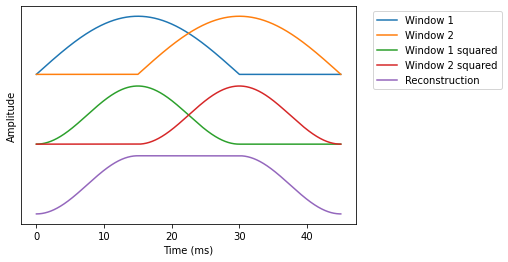

In [7]:
windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)

zero_vector = np.zeros(window_step,)
time_vectorx = np.linspace(0,window_length_ms+window_step_ms,window_length+window_step)

win1x = np.concatenate((windowing_function,zero_vector))
win2x = np.concatenate((zero_vector,windowing_function))

reconstruction = win1x**2 + win2x**2
display_shift = 1.2

fig, ax = plt.subplots()
ax.plot(time_vectorx,win1x,label='Window 1')
ax.plot(time_vectorx,win2x,label='Window 2')
ax.plot(time_vectorx,win1x**2-display_shift*1,label='Window 1 squared')
ax.plot(time_vectorx,win2x**2-display_shift*1,label='Window 2 squared')
ax.plot(time_vectorx,reconstruction-display_shift*2,label='Reconstruction')
ax.legend(bbox_to_anchor=(1.45, 1),loc='upper right')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude')
ax.set_yticks([])
plt.show()

### Overlap-add summary
Overlap-add is a method for windowing a signal such that we can modify the segments *and* reconstruct the modified signal.

*Algorithm*
1.  Applying windowing function $w_n$.
2.  Modify/process window with your-algorithm-of-choice.
3.  Applying windowing function $w_n$ again.
4.  Add overlapping segments together to obtain output signal.

Usually we would perform a time-frequency transform on the    windowed signal $w_nx_n$ and perform modifications in the    frequency-domain. (Almost) all frequency-domain processing algorithms are based on  overlap-add.



## The short-time Fourier transform (STFT)

Overlap-add is typically combined with taking discrete Fourier transforms of the windowed signal, as well as an inverse transforms after processing. This algorithm is known as the *short-time Fourier transform (STFT)* and it is the most commonly used domain for speech and audio processing. It is so common that often when we talk about a time-frequency transform in conjunction with processing algorithms, we implicitly mean the STFT.

*Algorithm*
1.  Applying windowing function $w_n$.
2.  Apply the discrete Fourier transform (DFT) on the windowed signal.
2.  Modify/process window with your-algorithm-of-choice.
3.  Apply the inverse DFT on the modified windows.
3.  Applying windowing function $w_n$ again.
4.  Add overlapping segments together to obtain output signal.
